In [21]:
'''
Alex DeGrace 300071786
Gabriel St-Pierre 300146514
'''

import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 13000), started 0:16:39 ago. (Use '!kill 13000' to kill it.)

In [22]:
# Dont't forget to get the data from Kaggle (https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer) and make sure that they are in the data folder.
# The data folder should look something like this: ./data/train/ and ./data/test/.
# Both folder should have these different subfolder full of png:"" angry, discusted, fearful, happy, neutral, sad and surprised.

# Array containing all possible class
classes = ["angry","disgusted","fearful","happy","neutral","sad","surprised"]
# Array containing train and test for looping
folders_name = ["train","test"]
dir_path = './data'

folder_img_count_array = []
# Loop trough the folders_name array so that we visit both folders
for folder_name in folders_name:
    folder_img_count = 0
    class_distribution_array = []
    #Loop trough the class dictionary so that we go inside each class folders
    for c in classes:
        current_dir_path = dir_path + "/" + folder_name + "/" + c
        count = 0
        # Iterate directory
        for file_path in os.listdir(current_dir_path):
            # check if current path is a file
            if os.path.isfile(os.path.join(current_dir_path, file_path)):
                count += 1
                folder_img_count += 1
        class_distribution_array.append(count)
    folder_img_count_array.append(folder_img_count)
    #Print the class distribution of each dataset (train/test)
    print(f"{folder_name} percentage of angry image: {class_distribution_array[0]/folder_img_count*100:.2f}%")
    print(f"{folder_name} percentage of disgusted image: {class_distribution_array[1]/folder_img_count*100:.2f}%")
    print(f"{folder_name} percentage of fearful image: {class_distribution_array[2]/folder_img_count*100:.2f}%")
    print(f"{folder_name} percentage of happy image: {class_distribution_array[3]/folder_img_count*100:.2f}%")
    print(f"{folder_name} percentage of neutral image: {class_distribution_array[4]/folder_img_count*100:.2f}%")
    print(f"{folder_name} percentage of sad image: {class_distribution_array[5]/folder_img_count*100:.2f}%")
    print(f"{folder_name} percentage of surprised image: {class_distribution_array[6]/folder_img_count*100:.2f}%")
    print("Total number of",folder_name,"data:",folder_img_count)
    print("----------------------------------------------")

total_num_image = folder_img_count_array[0] + folder_img_count_array[1]
#The total number of training images is 80% but 25% of the 80% (20% total) will be use for validation
print(f"Percentage of image for training: {folder_img_count_array[0]/total_num_image*100:.2f}%")
print(f"Percentage of image for test: {folder_img_count_array[1]/total_num_image*100:.2f}%")


train percentage of angry image: 13.92%
train percentage of disgusted image: 1.52%
train percentage of fearful image: 14.27%
train percentage of happy image: 25.13%
train percentage of neutral image: 17.29%
train percentage of sad image: 16.82%
train percentage of surprised image: 11.05%
Total number of train data: 28709
----------------------------------------------
test percentage of angry image: 13.35%
test percentage of disgusted image: 1.55%
test percentage of fearful image: 14.27%
test percentage of happy image: 24.71%
test percentage of neutral image: 17.18%
test percentage of sad image: 17.37%
test percentage of surprised image: 11.58%
Total number of test data: 7178
----------------------------------------------
Percentage of image for training: 80.00%
Percentage of image for test: 20.00%


./data/train
Found 21535 images belonging to 7 classes.
Found 7174 images belonging to 7 classes.
Printing the first image in the train_generator


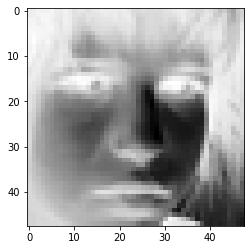

In [23]:

# Specify the batch size
batch_size = 64


#Create the training ImageGenerator to feed our model more and different data so that can perform better 
image_generator_training = ImageDataGenerator(
    fill_mode='nearest',
    brightness_range=[0.5,1.5],
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255,
    validation_split=0.25 # takes 25% of test data for validation (20% of total data)
)

#Trainning directory path
train_dir = dir_path + "/" + folders_name[0]
print(train_dir)

# Saving the augmented data was causing errors.

train_generator = image_generator_training.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    #classes=classes,
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True,
    seed=SEED,
    # save_to_dir="./augemented_data",
    # save_prefix='agm_img',
    # save_format='png',
    subset="training",
    interpolation='nearest'
)

val_generator = image_generator_training.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    #classes=classes,
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True,
    seed=SEED,
    # save_to_dir="./augemented_data",
    # save_prefix='agm_img',
    # save_format='png',
    subset="validation",
    interpolation='nearest'
)



# Printing the first image in the train_generator
print("Printing the first image in the train_generator")
for i, element in enumerate(train_generator):
    plt.imshow(element[0][1], cmap=plt.cm.binary)
    break

In [24]:
def make_directories():
    d = datetime.datetime.today()
    timestamp = d.strftime('%Y%m%d_%H%M%S')
    # folder to store the tensorboard logs
    tensorlog_folder = os.path.join(os.path.curdir, 'logs', timestamp)
    # folder to store the trained models
    checkpoint_folder = os.path.join(os.path.curdir, 'models', timestamp)

    os.mkdir(tensorlog_folder)
    os.mkdir(checkpoint_folder)

    return checkpoint_folder, tensorlog_folder

In [31]:
inputs = keras.Input(shape=(48,48,1))

x = layers.Conv2D(filters=32, kernel_size=4, activation="relu", name="conv2d_1")(inputs) 
x = layers.MaxPooling2D(pool_size=2,padding="same", name="max_pooling2d_1")(x) 
x = layers.Dense(32, activation="relu", name="dense1")(x) 
x = layers.Flatten(name="flatten")(x)
output = layers.Dense(10, activation='softmax', name='dense_out')(x)

model = keras.Model(inputs=inputs, outputs=output)

print(model.summary())

model_metrics = ['accuracy']

opt = keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", loss_weights=0.5, metrics=model_metrics)



early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoints = keras.callbacks.ModelCheckpoint(
    filepath="models",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

tensorboard = keras.callbacks.TensorBoard(
    log_dir="logs"
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=5e-7,
    verbose=1
)

model.fit(
    x=train_generator,
    y=None,
    batch_size=batch_size,
    epochs=15,
    callbacks=[reduce_lr, early_stop, checkpoints, tensorboard],
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples/batch_size,
    validation_steps=val_generator.samples/batch_size,
    validation_batch_size=batch_size,
)


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dense1 (Dense)               (None, 23, 23, 32)        1056      
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0         
_________________________________________________________________
dense_out (Dense)            (None, 10)                169290    
Total params: 170,890
Trainable params: 170,890
Non-trainable params: 0
_____________________________________________________